In [86]:
import numpy as np
import sklearn as skl
import csv
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix

In [61]:
# Reading of the information matrix

node_inf_raw = pd.read_csv("./node_information.csv")
node_inf = node_inf_raw.values
for i in range(len(node_inf)):
    if type(node_inf[i][3]) == float:
        node_inf[i][3] = set()
    else:
        node_inf[i][3] = set(node_inf[i][3].split(", "))
    
    if type(node_inf[i][4]) == float:
        node_inf[i][4] = ''

In [62]:
train_raw = np.array(pd.read_csv("./paul_my_train.csv").values)

In [63]:
import networkx as nx

In [64]:
graph = nx.DiGraph()

In [67]:
for a in node_inf:
    graph.add_node(a[0], year = int(a[1]))

In [68]:
for a in train_raw:
    if a[2] == 1:
        if graph.node[a[0]]["year"] < graph.node[a[1]]["year"]:
            graph.add_edge(a[0], a[1])
        else:
            graph.add_edge(a[1], a[0])

In [69]:
maxdeg = 0

for i in graph.nodes:
    if graph.degree(i) > maxdeg:
        maxdeg = graph.degree(i)

In [70]:
print("Le degré max est:",maxdeg)

('Le degr\xc3\xa9 max est:', 1871)


In [71]:
#print("Il y a ",len(list(nx.connected_components(graph))), "composantes connexes.")

In [72]:
nx.has_path(graph, 1001, 1002)

False

In [73]:
#nx.draw(graph)
#plt.show()

In [74]:
nx.shortest_path_length(graph, 1001, 1002)

NetworkXNoPath: No path between 1001 and 1002.

In [75]:
test = np.array(pd.read_csv("./paul_my_test.csv").values)

In [76]:
test[:10]

array([[ 206062,  205067,       1],
       [ 202039,  112255,       0],
       [9810163, 9306137,       0],
       [  11290,   10014,       1],
       [ 208112, 9305025,       0],
       [9905180, 9706096,       1],
       [9911149, 9608024,       1],
       [  10190,    6240,       1],
       [9810099, 9810072,       1],
       [9905212, 9903056,       1]], dtype=int64)

In [77]:
for a in test[:10]:
    print(nx.shortest_path_length(graph,a[0],a[1]))

NetworkXNoPath: No path between 206062 and 205067.

In [78]:
for a in test[:10]:
    print(graph.degree(a[0])+graph.degree(a[1]))

158
30
13
53
66
76
353
149
237
52


In [79]:
data_test = np.array([[nx.shortest_path_length(graph,a[0],a[1]) if nx.has_path(graph, a[0], a[1]) else -1, graph.degree(a[0])+graph.degree(a[1])] for a in test])


In [80]:
data_test

array([[ -1, 158],
       [ -1,  30],
       [ -1,  13],
       ..., 
       [ -1,  32],
       [ -1,   7],
       [ -1, 300]])

In [81]:
sum(test[data_test[:,0]==-1][:,2]==1)/len(test[data_test[:,0]==-1][:,2])

0

In [82]:
max(data_test[:, 0])

20

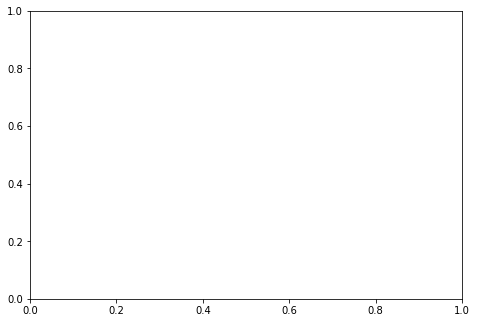

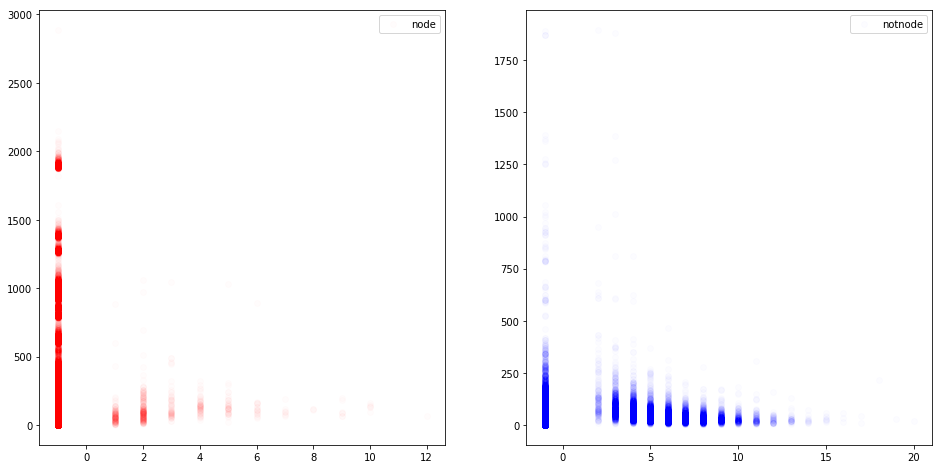

In [83]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.scatter(data_test[test[:,2]==1][:,0], data_test[test[:,2]==1][:,1], label="node", alpha=0.01, c="r")
plt.legend()
plt.subplot(122)
plt.scatter(data_test[test[:,2]==0][:,0], data_test[test[:,2]==0][:,1], label="notnode", alpha=0.01, c="b")
plt.legend()
plt.show()

In [ ]:
spare_matrix = nx.to_scipy_sparse_matrix(graph)
#spare_matrix = csc_matrix(array_matrix,dtype=np.float)

q = 0.15
error = 0.001

ri, ci = spare_matrix.nonzero()
matsums = np.array(spare_matrix.sum(1))[:,0]
spare_matrix.data /= matsums[ri]
puit = matsums == 0

n = spare_matrix.shape[0]
pro, pr = np.zeros(n), np.ones(n)
while np.sum(np.abs(pr-pro)) > error:
    pro = pr.copy()
    # calculate each pagerank at a time
    for i in xrange(0,n):
        smi = np.array(spare_matrix[:,i].todense())[:,0]
        Bi = puit / float(n)
        Ci = np.ones(n) / float(n)

        pr[i] = pro.dot( smi*q + Bi*q + Ci*(1-q) )

    # return normalized pagerank
pagerank = pr/float(sum(pr))

print(pagerank[:10])

In [ ]:

data_train = []

for a in train_raw:
    if a[2] == 1:
        if graph.node[a[0]]['year'] < graph.node[a[1]]['year']:
            graph.remove_edge(a[0], a[1])
        else:
            graph.remove_edge(a[1], a[0])
    data_train.append([nx.shortest_path_length(graph,a[0],a[1]) if nx.has_path(graph, a[0], a[1]) else -1,
                       graph.degree(a[0])+graph.degree(a[1])])
    if a[2] == 1:
        if graph.node[a[0]]['year'] < graph.node[a[1]]['year']:
            graph.add_edge(a[0], a[1])
        else:
            graph.add_edge(a[1], a[0])

data_train = np.array(data_train)

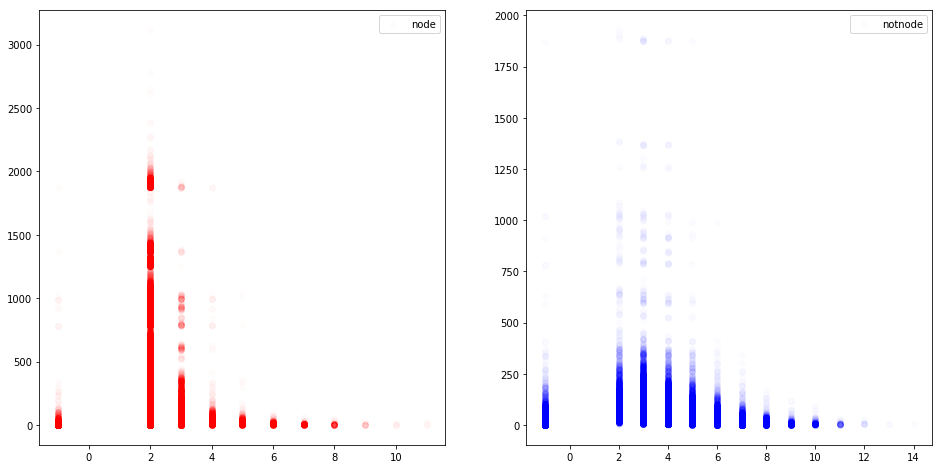

In [70]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.scatter(data_train[train_raw[:,2]==1][:,0], data_train[train_raw[:,2]==1][:,1], label="node", alpha=0.01, c="r")
plt.legend()
plt.subplot(122)
plt.scatter(data_train[train_raw[:,2]==0][:,0], data_train[train_raw[:,2]==0][:,1], label="notnode", alpha=0.01, c="b")
plt.legend()
plt.show()

In [72]:
with open("./paul_train_graph.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["dist", "sum_deg"])
    for a in data_train:
        writer.writerow(a)

In [73]:
with open("./paul_test_graph.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["dist", "sum_deg"])
    for a in data_test:
        writer.writerow(a)

In [75]:
kaggle = np.array(pd.read_csv("./testing_set.txt", delimiter=" ", header=None))

print(kaggle)

data_kaggle = np.array([[nx.shortest_path_length(graph,a[0],a[1]) if nx.has_path(graph, a[0], a[1]) else -1,
                       graph.degree(a[0])+graph.degree(a[1])] for a in kaggle])

[[9807076 9807139]
 [ 109162    1182]
 [9702187 9510135]
 ...
 [9608095 9205058]
 [9407008  106256]
 [ 208144    7142]]


In [76]:
with open("./paul_kaggle_graph.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["dist", "sum_deg"])
    for a in data_kaggle:
        writer.writerow(a)